FUZZY LOGIC ROBOTIC ARM CONTROLLER
Enter target angle (degrees): 45
Enter initial angle (degrees): 0
Enter time step (e.g., 0.05): 0.05
Enter control gain (e.g., 1.2): 1.2
Enter max steps (e.g., 1000): 1000
Enter control saturation limit (e.g., 50.0): 50
Starting simulation...
Target: 45.0°, Initial: 0.0°
Parameters: dt=0.05, gain=1.2, sat=50.0

⚠️ Did not converge within max steps.
Final angle = 45.453° (error = -0.453°)


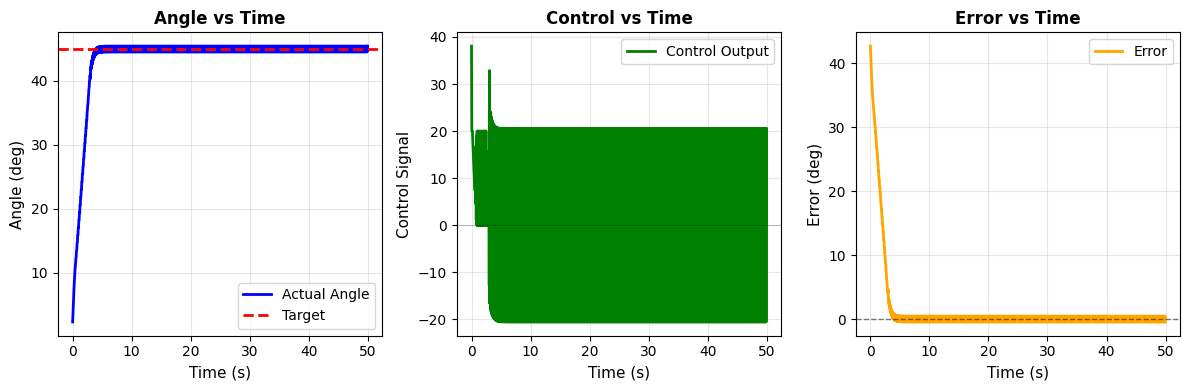


Creating animation of the robotic arm...


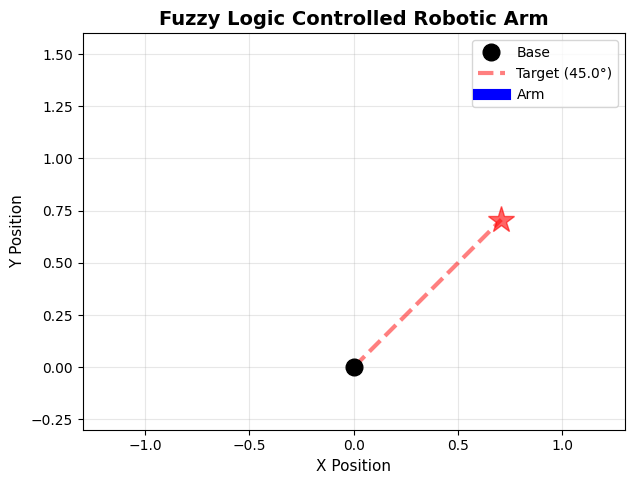


✨ Simulation complete!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# ---------- Triangular membership (vectorized) ----------
def trimf(x, a, b, c):
    """Vectorized triangular membership function"""
    x = np.asarray(x)
    result = np.zeros_like(x, dtype=float)

    # Left slope
    left_mask = (x > a) & (x < b)
    result[left_mask] = (x[left_mask] - a) / (b - a)

    # Peak
    peak_mask = (x == b)
    result[peak_mask] = 1.0

    # Right slope
    right_mask = (x > b) & (x < c)
    result[right_mask] = (c - x[right_mask]) / (c - b)

    return result


# ---------- Configuration Parameters ----------
print("=" * 50)
print("FUZZY LOGIC ROBOTIC ARM CONTROLLER")
print("=" * 50)

target_angle = float(input("Enter target angle (degrees): "))
cur_angle = float(input("Enter initial angle (degrees): "))
dt = float(input("Enter time step (e.g., 0.05): "))
gain = float(input("Enter control gain (e.g., 1.2): "))
max_steps = int(input("Enter max steps (e.g., 1000): "))
control_sat = float(input("Enter control saturation limit (e.g., 50.0): "))

print("=" * 50)


# ---------- Define fuzzy sets for ERROR ----------
def err_large_neg(x):
    return trimf(x, -90, -60, -30)

def err_small_neg(x):
    return trimf(x, -40, -20, 0)

def err_zero(x):
    return trimf(x, -5, 0, 5)

def err_small_pos(x):
    return trimf(x, 0, 20, 40)

def err_large_pos(x):
    return trimf(x, 30, 60, 90)


# ---------- Define fuzzy sets for ERROR DERIVATIVE ----------
def derr_neg(x):
    return trimf(x, -50, -25, 0)

def derr_zero(x):
    return trimf(x, -10, 0, 10)

def derr_pos(x):
    return trimf(x, 0, 25, 50)


# ---------- Control output universe ----------
u_universe = np.linspace(-50, 50, 1001)


# ---------- Control fuzzy sets ----------
def u_large_neg(x):
    return trimf(x, -50, -40, -25)

def u_small_neg(x):
    return trimf(x, -35, -20, -5)

def u_zero(x):
    return trimf(x, -8, 0, 8)

def u_small_pos(x):
    return trimf(x, 5, 20, 35)

def u_large_pos(x):
    return trimf(x, 25, 40, 50)


# ---------- Rule evaluation (Mamdani) ----------
def evaluate_rules(e_val, de_val):
    """Evaluate fuzzy rules based on error and error derivative"""

    # Fuzzify inputs
    e_ln = err_large_neg(e_val)
    e_sn = err_small_neg(e_val)
    e_z = err_zero(e_val)
    e_sp = err_small_pos(e_val)
    e_lp = err_large_pos(e_val)

    de_n = derr_neg(de_val)
    de_z = derr_zero(de_val)
    de_p = derr_pos(de_val)

    # Rule base: if error is POSITIVE (target > current) -> increase angle
    fired = []

    # Large negative error (current > target, need to decrease)
    fired.append((min(e_ln, de_n), u_large_neg))
    fired.append((min(e_ln, de_z), u_large_neg))
    fired.append((min(e_ln, de_p), u_small_neg))

    # Small negative error
    fired.append((min(e_sn, de_n), u_large_neg))
    fired.append((min(e_sn, de_z), u_small_neg))
    fired.append((min(e_sn, de_p), u_zero))

    # Zero error (at target, maintain)
    fired.append((min(e_z, de_n), u_small_neg))
    fired.append((min(e_z, de_z), u_zero))
    fired.append((min(e_z, de_p), u_small_pos))

    # Small positive error (target > current, need to increase)
    fired.append((min(e_sp, de_n), u_zero))
    fired.append((min(e_sp, de_z), u_small_pos))
    fired.append((min(e_sp, de_p), u_large_pos))

    # Large positive error
    fired.append((min(e_lp, de_n), u_small_pos))
    fired.append((min(e_lp, de_z), u_large_pos))
    fired.append((min(e_lp, de_p), u_large_pos))

    return fired


# ---------- Defuzzify (centroid) ----------
def defuzz_centroid(combined_mf, u_univ):
    """Compute centroid defuzzification"""
    num = np.sum(combined_mf * u_univ)
    den = np.sum(combined_mf)
    if den < 1e-10:
        return 0.0
    return num / den


# ---------- Combine fired rules ----------
def aggregate(fired, u_univ):
    """Aggregate all fired rules using maximum operator"""
    agg = np.zeros_like(u_univ)
    for strength, mf_func in fired:
        if strength <= 0:
            continue
        vals = mf_func(u_univ)
        vals = np.minimum(strength, vals)
        agg = np.maximum(agg, vals)
    return agg


# ---------- Simulation ----------
print(f"Starting simulation...")
print(f"Target: {target_angle}°, Initial: {cur_angle}°")
print(f"Parameters: dt={dt}, gain={gain}, sat={control_sat}")

time_hist, angle_hist, control_hist = [], [], []
prev_error = target_angle - cur_angle
stable_steps = 0

for step in range(max_steps):
    e = target_angle - cur_angle
    de = (e - prev_error) / dt

    fired = evaluate_rules(e, de)
    agg = aggregate(fired, u_universe)
    u_out = defuzz_centroid(agg, u_universe)
    u_out = np.clip(u_out, -control_sat, control_sat)

    # Update angle with damping near target
    if abs(e) < 10:
        damping = -0.3 * de
        cur_angle += gain * (u_out + damping) * dt
    else:
        cur_angle += gain * u_out * dt

    prev_error = e
    time_hist.append(step * dt)
    angle_hist.append(cur_angle)
    control_hist.append(u_out)

    # Convergence check
    if abs(e) < 1.0 and abs(de) < 1.0:
        stable_steps += 1
        if stable_steps > 20:
            print(f"\n✅ Converged at step {step}, time = {step*dt:.2f}s")
            print(f"Final angle = {cur_angle:.3f}° (error = {e:.3f}°)")
            break
    else:
        stable_steps = 0
else:
    print(f"\n⚠️ Did not converge within max steps.")
    print(f"Final angle = {cur_angle:.3f}° (error = {target_angle - cur_angle:.3f}°)")


# ---------- Static Plots ----------
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(time_hist, angle_hist, color='b', linewidth=2, label='Actual Angle')
plt.axhline(target_angle, linestyle='--', color='r', linewidth=2, label='Target')
plt.xlabel('Time (s)', fontsize=11)
plt.ylabel('Angle (deg)', fontsize=11)
plt.title('Angle vs Time', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(time_hist, control_hist, color='g', linewidth=2, label='Control Output')
plt.axhline(0, linestyle='-', color='k', linewidth=0.5, alpha=0.3)
plt.xlabel('Time (s)', fontsize=11)
plt.ylabel('Control Signal', fontsize=11)
plt.title('Control vs Time', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
errors = [target_angle - a for a in angle_hist]
plt.plot(time_hist, errors, color='orange', linewidth=2, label='Error')
plt.axhline(0, linestyle='--', color='k', linewidth=1, alpha=0.5)
plt.xlabel('Time (s)', fontsize=11)
plt.ylabel('Error (deg)', fontsize=11)
plt.title('Error vs Time', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ---------- Robotic Arm Animation ----------
print("\nCreating animation of the robotic arm...")

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.3, 1.6)
ax.set_aspect('equal')
ax.set_title('Fuzzy Logic Controlled Robotic Arm', fontsize=14, fontweight='bold')

# Base
ax.plot(0, 0, 'ko', markersize=12, label='Base', zorder=5)

# Target position
target_x = np.sin(np.radians(target_angle))
target_y = np.cos(np.radians(target_angle))
ax.plot([0, target_x], [0, target_y], 'r--', linewidth=3, alpha=0.5, label=f'Target ({target_angle}°)')
ax.plot(target_x, target_y, 'r*', markersize=20, alpha=0.6, zorder=4)

# Arm
arm_line, = ax.plot([], [], 'b-', lw=8, label='Arm', zorder=3)
arm_end, = ax.plot([], [], 'go', markersize=12, zorder=4)

# Text displays
text_angle = ax.text(-1.2, 1.45, '', fontsize=11, weight='bold')
text_error = ax.text(-1.2, 1.35, '', fontsize=10)

ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlabel('X Position', fontsize=11)
ax.set_ylabel('Y Position', fontsize=11)


def init():
    arm_line.set_data([], [])
    arm_end.set_data([], [])
    text_angle.set_text('')
    text_error.set_text('')
    return arm_line, arm_end, text_angle, text_error


def update(frame):
    angle = angle_hist[frame]
    x = np.sin(np.radians(angle))
    y = np.cos(np.radians(angle))
    arm_line.set_data([0, x], [0, y])
    arm_end.set_data([x], [y])
    error = target_angle - angle
    text_angle.set_text(f"Angle: {angle:.2f}°")
    text_error.set_text(f"Error: {error:.2f}°")
    return arm_line, arm_end, text_angle, text_error


# Use fewer frames for smoother animation
frames = min(len(angle_hist), 500)
frame_step = max(1, len(angle_hist) // frames)

ani = FuncAnimation(
    fig, update, frames=range(0, len(angle_hist), frame_step),
    init_func=init, blit=True, interval=30, repeat=True
)

plt.show()
print("\n✨ Simulation complete!")
